In [1]:
import sys
sys.path.append('../')
from config_sing import *
show_env()

You are in: Singularity | singularity_proj_combeffect
    BASE DIRECTORY:     /mount/work
    PATH OF SOURCE:     /mount/work/source
    PATH OF EXECUTABLE: /mount/work/exe
    PATH OF ANNOTATION: /mount/work/annotation
    PATH OF PROJECT:    /mount/project
    PATH OF RESULTS:    /mount/work/out/proj_combeffect

Library imported:
    numpy, pandas, matplotlib.pyplot
    os, sys, time, gzip, glob



In [2]:
from sklearn import metrics
from sklearn.model_selection import train_test_split

import seaborn as sns
import xgboost as xgb
import shap
import json

In [3]:
from functools import partial, reduce
print = partial(print, flush=True)

### Set Samples
fun = np.core.defchararray.add
idx = np.arange(1,6).astype("str")

INPUT    = reduce(fun, ["Input", idx])
INPUT20X = reduce(fun, ["Input", idx,     "_20x"])
TFX_DMSO = reduce(fun, ["TFX",   idx[1:], "_DMSO"])
TFX_DEX  = reduce(fun, ["TFX",   idx[1:], "_Dex"])
SAMPLES  = np.concatenate([INPUT20X, TFX_DMSO, TFX_DEX])

In [4]:
from collections import Counter

In [5]:
def read_data(sample, fname, cnames):
    fdiry = os.path.join(FD_RES, "scratch", "region_dex_GR_P300_dnase_chr17")
    fname = f"{sample}_{fname}"
    fpath = os.path.join(fdiry, fname)
    dat   = pd.read_csv(fpath, sep = "\t", names=cnames)
    return dat

read_motif_score = partial(
    read_data, 
    fname="motif_score.tsv", 
    cnames=["Fragment", "Motif"])

read_motif_count = partial(
    read_data, 
    fname="motif_count.tsv", 
    cnames=["Fragment", "Motif"])

read_pct = partial(
    read_data, 
    fname="pct.tsv", 
    cnames=["Fragment", "GC"])

read_depth = partial(
    read_data, 
    fname="depth.tsv", 
    cnames=["Fragment", "Loc", "Depth"])

## Import DMSO

In [6]:
fun = read_motif_score
lst = list(map(fun, TFX_DMSO))

fun = lambda df1, df2: pd.concat([df1, df2])
dat = reduce(fun, lst)

### assign and show
dat_dmso_mtf_score = dat
print(dat.shape)
print(dat.drop_duplicates().shape)
dat

(10802, 2)
(10016, 2)


,Fragment,Motif
0,chr17_6001570_6002624,"{""HD/23"": 10.0246, ""SOX/1"": 15.42495, ""EVI1/ME..."
1,chr17_6001571_6002624,"{""SOX/1"": 15.42495, ""EVI1/MECOM"": 7.0973, ""ZNF..."
2,chr17_6001762_6002691,"{""ZNF549"": 13.8719, ""FEZF1"": 15.2109, ""GCM"": 7..."
3,chr17_6001762_6002692,"{""ZNF549"": 13.8719, ""FEZF1"": 15.2109, ""GCM"": 7..."
4,chr17_6001763_6002692,"{""ZNF549"": 13.8719, ""FEZF1"": 15.2109, ""GCM"": 7..."
...,...,...
2606,chr17_82268021_82268899,"{""NR/4"": 8.857, ""E2F/2"": 18.1223, ""ZFX"": 18.50..."
2607,chr17_82268031_82268998,"{""Ebox/CAGATGG"": 25.37525, ""ZNF768"": 19.6749, ..."
2608,chr17_82268031_82268999,"{""Ebox/CAGATGG"": 25.37525, ""ZNF768"": 19.6749, ..."
2609,chr17_82268032_82268997,"{""Ebox/CAGATGG"": 25.37525, ""ZNF768"": 19.6749, ..."


In [7]:
fun = read_motif_count
lst = list(map(fun, TFX_DMSO))

fun = lambda df1, df2: pd.concat([df1, df2])
dat = reduce(fun, lst)

### assign and show
dat_dmso_mtf_count = dat
print(dat.shape)
print(dat.drop_duplicates().shape)
dat

(10802, 2)
(10016, 2)


,Fragment,Motif
0,chr17_6001570_6002624,"{""HD/23"": 1, ""SOX/1"": 2, ""EVI1/MECOM"": 1, ""ZNF..."
1,chr17_6001571_6002624,"{""SOX/1"": 2, ""EVI1/MECOM"": 1, ""ZNF768"": 1, ""NF..."
2,chr17_6001762_6002691,"{""ZNF549"": 2, ""FEZF1"": 2, ""GCM"": 1, ""SIX/1"": 1..."
3,chr17_6001762_6002692,"{""ZNF549"": 2, ""FEZF1"": 2, ""GCM"": 1, ""SIX/1"": 1..."
4,chr17_6001763_6002692,"{""ZNF549"": 2, ""FEZF1"": 2, ""GCM"": 1, ""SIX/1"": 1..."
...,...,...
2606,chr17_82268021_82268899,"{""NR/4"": 1, ""E2F/2"": 2, ""ZFX"": 2, ""NR/3"": 4, ""..."
2607,chr17_82268031_82268998,"{""Ebox/CAGATGG"": 3, ""ZNF768"": 3, ""Ebox/CAGCTG""..."
2608,chr17_82268031_82268999,"{""Ebox/CAGATGG"": 3, ""ZNF768"": 3, ""Ebox/CAGCTG""..."
2609,chr17_82268032_82268997,"{""Ebox/CAGATGG"": 3, ""ZNF768"": 3, ""Ebox/CAGCTG""..."


In [8]:
fun = read_pct
lst = list(map(fun, TFX_DMSO))

fun = lambda df1, df2: pd.concat([df1, df2])
dat = reduce(fun, lst)

### assign and show
dat_dmso_pct = dat
print(dat.shape)
print(dat.drop_duplicates().shape)
dat

(10802, 2)
(10016, 2)


,Fragment,GC
0,chr17_6001570_6002624,0.541746
1,chr17_6001571_6002624,0.542260
2,chr17_6001762_6002691,0.528525
3,chr17_6001762_6002692,0.527957
4,chr17_6001763_6002692,0.528525
...,...,...
2606,chr17_82268021_82268899,0.535308
2607,chr17_82268031_82268998,0.529473
2608,chr17_82268031_82268999,0.528926
2609,chr17_82268032_82268997,0.528497


In [9]:
fun = read_depth
lst = list(map(fun, TFX_DMSO))

fun = lambda df1, df2: pd.concat([df1, df2])
dat = reduce(fun, lst)

### assign and show
dat_dmso_depth = dat
print(dat.shape)
print(dat.drop_duplicates().shape)
dat

(10802, 3)
(10016, 3)


,Fragment,Loc,Depth
0,chr17_6001570_6002624,6002097,"{""Input"": 4.13106, ""Input_20x"": 4.87901, ""TFX_..."
1,chr17_6001571_6002624,6002097,"{""Input"": 4.13106, ""Input_20x"": 4.87901, ""TFX_..."
2,chr17_6001762_6002691,6002226,"{""Input"": 4.79491, ""Input_20x"": 5.51811, ""TFX_..."
3,chr17_6001762_6002692,6002227,"{""Input"": 4.79491, ""Input_20x"": 5.51525, ""TFX_..."
4,chr17_6001763_6002692,6002227,"{""Input"": 4.79491, ""Input_20x"": 5.51525, ""TFX_..."
...,...,...,...
2606,chr17_82268021_82268899,82268460,"{""Input"": 6.91121, ""Input_20x"": 6.95478, ""TFX_..."
2607,chr17_82268031_82268998,82268514,"{""Input"": 6.7267, ""Input_20x"": 6.79834, ""TFX_D..."
2608,chr17_82268031_82268999,82268515,"{""Input"": 6.7267, ""Input_20x"": 6.80122, ""TFX_D..."
2609,chr17_82268032_82268997,82268514,"{""Input"": 6.7267, ""Input_20x"": 6.79834, ""TFX_D..."


## Import Dex

In [10]:
fun = read_motif_score
lst = list(map(fun, TFX_DEX))

fun = lambda df1, df2: pd.concat([df1, df2])
dat = reduce(fun, lst)

### assign and show
dat_dex_mtf_score = dat
print(dat.shape)
print(dat.drop_duplicates().shape)
dat

(39176, 2)
(30742, 2)


,Fragment,Motif
0,chr17_6001786_6002741,"{""SIX/1"": 8.5294, ""HIC/1"": 24.9856, ""P53-like/..."
1,chr17_6001796_6002785,"{""HIC/1"": 24.9856, ""P53-like/1"": 18.1449, ""GC-..."
2,chr17_6001796_6002786,"{""HIC/1"": 24.9856, ""P53-like/1"": 18.1449, ""GC-..."
3,chr17_6001797_6002783,"{""HIC/1"": 24.9856, ""P53-like/1"": 18.1449, ""GC-..."
4,chr17_6001797_6002786,"{""HIC/1"": 24.9856, ""P53-like/1"": 18.1449, ""GC-..."
...,...,...
11873,chr17_82267754_82268685,"{""MAF"": 9.6645, ""Ebox/CAGATGG"": 35.51705, ""ZNF..."
11874,chr17_82267762_82268716,"{""ZNF320"": 21.0008, ""GC-tract"": 53.11818, ""SMA..."
11875,chr17_82267763_82268716,"{""ZNF320"": 21.0008, ""GC-tract"": 53.11818, ""SMA..."
11876,chr17_82267768_82268716,"{""SMARCA5"": 11.531, ""ZNF143"": 6.6565, ""ZNF134""..."


In [11]:
fun = read_motif_count
lst = list(map(fun, TFX_DEX))

fun = lambda df1, df2: pd.concat([df1, df2])
dat = reduce(fun, lst)

### assign and show
dat_dex_mtf_count = dat
print(dat.shape)
print(dat.drop_duplicates().shape)
dat

(39176, 2)
(30742, 2)


,Fragment,Motif
0,chr17_6001786_6002741,"{""SIX/1"": 1, ""HIC/1"": 3, ""P53-like/1"": 2, ""GC-..."
1,chr17_6001796_6002785,"{""HIC/1"": 3, ""P53-like/1"": 2, ""GC-tract"": 6, ""..."
2,chr17_6001796_6002786,"{""HIC/1"": 3, ""P53-like/1"": 2, ""GC-tract"": 6, ""..."
3,chr17_6001797_6002783,"{""HIC/1"": 3, ""P53-like/1"": 2, ""GC-tract"": 6, ""..."
4,chr17_6001797_6002786,"{""HIC/1"": 3, ""P53-like/1"": 2, ""GC-tract"": 6, ""..."
...,...,...
11873,chr17_82267754_82268685,"{""MAF"": 1, ""Ebox/CAGATGG"": 4, ""ZNF320"": 2, ""GC..."
11874,chr17_82267762_82268716,"{""ZNF320"": 2, ""GC-tract"": 6, ""SMARCA5"": 2, ""ZN..."
11875,chr17_82267763_82268716,"{""ZNF320"": 2, ""GC-tract"": 6, ""SMARCA5"": 2, ""ZN..."
11876,chr17_82267768_82268716,"{""SMARCA5"": 2, ""ZNF143"": 1, ""ZNF134"": 2, ""INSM..."


In [12]:
fun = read_pct
lst = list(map(fun, TFX_DEX))

fun = lambda df1, df2: pd.concat([df1, df2])
dat = reduce(fun, lst)

### assign and show
dat_dex_pct = dat
print(dat.shape)
print(dat.drop_duplicates().shape)
dat

(39176, 2)
(30742, 2)


,Fragment,GC
0,chr17_6001786_6002741,0.524607
1,chr17_6001796_6002785,0.527806
2,chr17_6001796_6002786,0.527273
3,chr17_6001797_6002783,0.526369
4,chr17_6001797_6002786,0.526795
...,...,...
11873,chr17_82267754_82268685,0.555317
11874,chr17_82267762_82268716,0.557652
11875,chr17_82267763_82268716,0.557188
11876,chr17_82267768_82268716,0.556962


In [13]:
fun = read_depth
lst = list(map(fun, TFX_DEX))

fun = lambda df1, df2: pd.concat([df1, df2])
dat = reduce(fun, lst)

### assign and show
dat_dex_depth = dat
print(dat.shape)
print(dat.drop_duplicates().shape)
dat

(39176, 3)
(30742, 3)


,Fragment,Loc,Depth
0,chr17_6001786_6002741,6002263,"{""Input"": 4.77924, ""Input_20x"": 5.64975, ""TFX_..."
1,chr17_6001796_6002785,6002290,"{""Input"": 4.86016, ""Input_20x"": 5.70985, ""TFX_..."
2,chr17_6001796_6002786,6002291,"{""Input"": 4.86016, ""Input_20x"": 5.70697, ""TFX_..."
3,chr17_6001797_6002783,6002290,"{""Input"": 4.86016, ""Input_20x"": 5.70985, ""TFX_..."
4,chr17_6001797_6002786,6002291,"{""Input"": 4.86016, ""Input_20x"": 5.70697, ""TFX_..."
...,...,...,...
11873,chr17_82267754_82268685,82268219,"{""Input"": 7.87876, ""Input_20x"": 7.64433, ""TFX_..."
11874,chr17_82267762_82268716,82268239,"{""Input"": 7.55344, ""Input_20x"": 7.53848, ""TFX_..."
11875,chr17_82267763_82268716,82268239,"{""Input"": 7.55344, ""Input_20x"": 7.53848, ""TFX_..."
11876,chr17_82267768_82268716,82268242,"{""Input"": 7.45786, ""Input_20x"": 7.49217, ""TFX_..."


## Combine

In [14]:
dat1 = dat_dmso_mtf_score
dat2 = dat_dmso_pct
dat3 = dat_dmso_depth

print(np.all(dat1.Fragment == dat2.Fragment))
print(np.all(dat1.Fragment == dat3.Fragment))

True
True


```
dat = dat1
dat = pd.merge(dat, dat2, how='outer', left_on='Fragment', right_on='Fragment')
dat = pd.merge(dat, dat3, how='outer', left_on='Fragment', right_on='Fragment')
print(dat.shape)
dat = dat.drop_duplicates()
print(dat.shape)
dat_dmso = dat
```

In [15]:
dat1 = dat_dex_mtf_score
dat2 = dat_dex_pct
dat3 = dat_dex_depth

print(np.all(dat1.Fragment == dat2.Fragment))
print(np.all(dat1.Fragment == dat3.Fragment))

True
True


```
dat = dat1
dat = pd.merge(dat, dat2, how='outer', left_on='Fragment', right_on='Fragment')
dat = pd.merge(dat, dat3, how='outer', left_on='Fragment', right_on='Fragment')
print(dat.shape)
dat = dat.drop_duplicates()
print(dat.shape)
dat_dex = dat
```

In [25]:
lst = dat_dmso_mtf_score["Motif"].to_list() + dat_dex_mtf_score["Motif"].to_list()
lst = list(map(json.loads, lst))
dat_mtf_score = pd.DataFrame.from_dict(lst).fillna(0)
dat_mtf_score

,HD/23,SOX/1,EVI1/MECOM,ZNF768,NFY,EBF1,GC-tract,ZNF320,CTCF,KLF/SP/2,...,HSFY2,NR/4,ZNF713,TATA,AHR,ARI5B,GMEB2/1,ZBTB14,GMEB2/2,KAISO
0,10.0246,15.42495,7.0973,7.0552,7.4972,8.3990,78.25626,17.3581,14.9269,83.21312,...,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0000,15.42495,7.0973,7.0552,7.4972,8.3990,78.25626,17.3581,14.9269,83.21312,...,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0000,15.96585,0.0000,0.0000,0.0000,0.0000,59.84730,0.0000,6.1980,64.11863,...,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0000,15.96585,0.0000,0.0000,0.0000,0.0000,59.84730,0.0000,6.1980,64.11863,...,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0000,15.96585,0.0000,0.0000,0.0000,0.0000,59.84730,0.0000,6.1980,64.11863,...,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49973,0.0000,6.82580,0.0000,29.9513,0.0000,9.5487,53.11818,21.0008,26.5810,29.74041,...,0.0,8.857,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
49974,0.0000,6.82580,0.0000,29.9513,0.0000,9.5487,53.11818,21.0008,26.5810,29.74041,...,0.0,8.857,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
49975,0.0000,6.82580,0.0000,29.9513,0.0000,9.5487,53.11818,21.0008,26.5810,29.74041,...,0.0,8.857,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
49976,0.0000,6.82580,0.0000,29.9513,0.0000,9.5487,43.15858,9.6538,26.5810,29.74041,...,0.0,8.857,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
lst = dat_dmso_mtf_count["Motif"].to_list() + dat_dex_mtf_count["Motif"].to_list()
lst = list(map(json.loads, lst))
dat_mtf_count = pd.DataFrame.from_dict(lst).fillna(0)
dat_mtf_count

,HD/23,SOX/1,EVI1/MECOM,ZNF768,NFY,EBF1,GC-tract,ZNF320,CTCF,KLF/SP/2,...,HSFY2,NR/4,ZNF713,TATA,AHR,ARI5B,GMEB2/1,ZBTB14,GMEB2/2,KAISO
0,1.0,2.0,1.0,1.0,1.0,1.0,8.0,2.0,2.0,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,2.0,1.0,1.0,1.0,1.0,8.0,2.0,2.0,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,2.0,0.0,0.0,0.0,0.0,6.0,0.0,1.0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,2.0,0.0,0.0,0.0,0.0,6.0,0.0,1.0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,2.0,0.0,0.0,0.0,0.0,6.0,0.0,1.0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49973,0.0,1.0,0.0,4.0,0.0,1.0,6.0,2.0,3.0,4.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
49974,0.0,1.0,0.0,4.0,0.0,1.0,6.0,2.0,3.0,4.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
49975,0.0,1.0,0.0,4.0,0.0,1.0,6.0,2.0,3.0,4.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
49976,0.0,1.0,0.0,4.0,0.0,1.0,5.0,1.0,3.0,4.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
lst = dat_dmso_depth["Depth"].to_list() + dat_dex_depth["Depth"].to_list()
lst = list(map(json.loads, lst))
dat_depth = pd.DataFrame.from_dict(lst).fillna(0)
dat_depth

,Input,Input_20x,TFX_DMSO,TFX_Dex
0,4.13106,4.87901,2.41356,2.25058
1,4.13106,4.87901,2.41356,2.25058
2,4.79491,5.51811,2.87105,2.53684
3,4.79491,5.51525,2.87105,2.53684
4,4.79491,5.51525,2.87105,2.53684
...,...,...,...,...
49973,7.87876,7.64433,13.23422,23.23000
49974,7.55344,7.53848,12.43331,22.14264
49975,7.55344,7.53848,12.43331,22.14264
49976,7.45786,7.49217,12.37819,22.07497


In [18]:
dat_pct = dat_dmso_pct["GC"].to_list() + dat_dex_pct["GC"].to_list()
print(len(dat_pct))

49978


In [19]:
dat_comb = dat_mtf.assign(
    GC    = dat_pct,
    Input = dat_depth["Input_20x"]
)
dat_comb

,HD/23,SOX/1,EVI1/MECOM,ZNF768,NFY,EBF1,GC-tract,ZNF320,CTCF,KLF/SP/2,...,ZNF713,TATA,AHR,ARI5B,GMEB2/1,ZBTB14,GMEB2/2,KAISO,GC,Input
0,10.0246,15.42495,7.0973,7.0552,7.4972,8.3990,78.25626,17.3581,14.9269,83.21312,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.541746,4.87901
1,0.0000,15.42495,7.0973,7.0552,7.4972,8.3990,78.25626,17.3581,14.9269,83.21312,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.542260,4.87901
2,0.0000,15.96585,0.0000,0.0000,0.0000,0.0000,59.84730,0.0000,6.1980,64.11863,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.528525,5.51811
3,0.0000,15.96585,0.0000,0.0000,0.0000,0.0000,59.84730,0.0000,6.1980,64.11863,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.527957,5.51525
4,0.0000,15.96585,0.0000,0.0000,0.0000,0.0000,59.84730,0.0000,6.1980,64.11863,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.528525,5.51525
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49973,0.0000,6.82580,0.0000,29.9513,0.0000,9.5487,53.11818,21.0008,26.5810,29.74041,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.555317,7.64433
49974,0.0000,6.82580,0.0000,29.9513,0.0000,9.5487,53.11818,21.0008,26.5810,29.74041,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.557652,7.53848
49975,0.0000,6.82580,0.0000,29.9513,0.0000,9.5487,53.11818,21.0008,26.5810,29.74041,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.557188,7.53848
49976,0.0000,6.82580,0.0000,29.9513,0.0000,9.5487,43.15858,9.6538,26.5810,29.74041,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.556962,7.49217


In [27]:
dat_comb = dat_mtf_count.assign(
    GC    = dat_pct,
    Input = dat_depth["Input_20x"]
)
dat_comb

,HD/23,SOX/1,EVI1/MECOM,ZNF768,NFY,EBF1,GC-tract,ZNF320,CTCF,KLF/SP/2,...,ZNF713,TATA,AHR,ARI5B,GMEB2/1,ZBTB14,GMEB2/2,KAISO,GC,Input
0,1.0,2.0,1.0,1.0,1.0,1.0,8.0,2.0,2.0,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.541746,4.87901
1,0.0,2.0,1.0,1.0,1.0,1.0,8.0,2.0,2.0,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.542260,4.87901
2,0.0,2.0,0.0,0.0,0.0,0.0,6.0,0.0,1.0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.528525,5.51811
3,0.0,2.0,0.0,0.0,0.0,0.0,6.0,0.0,1.0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.527957,5.51525
4,0.0,2.0,0.0,0.0,0.0,0.0,6.0,0.0,1.0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.528525,5.51525
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49973,0.0,1.0,0.0,4.0,0.0,1.0,6.0,2.0,3.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.555317,7.64433
49974,0.0,1.0,0.0,4.0,0.0,1.0,6.0,2.0,3.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.557652,7.53848
49975,0.0,1.0,0.0,4.0,0.0,1.0,6.0,2.0,3.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.557188,7.53848
49976,0.0,1.0,0.0,4.0,0.0,1.0,5.0,1.0,3.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.556962,7.49217


## fit model

In [28]:
ftr    = dat_comb.columns.values
n_dmso = dat_dmso_pct.shape[0]
n_dex  = dat_dex_pct.shape[0]
X      = dat_comb
y      = np.r_[np.repeat(0, n_dmso), np.repeat(1, n_dex)]

print(type(X),   X.shape)
print(type(y),   y.shape)
print(type(ftr), ftr.shape)
Counter(y)

<class 'pandas.core.frame.DataFrame'> (49978, 271)
<class 'numpy.ndarray'> (49978,)
<class 'numpy.ndarray'> (271,)


Counter({0: 10802, 1: 39176})

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [30]:
model = xgb.XGBClassifier()
model.fit(X_train, y_train)
print(model)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)


In [31]:
y_expc = y_test
y_pred = model.predict(X_test)

print("Accuracy")
print(metrics.classification_report(y_expc, y_pred))
print("+++++++++++++++++++++++++++++++++++++++++++")
print("Confusion Matrix")
print(metrics.confusion_matrix(y_expc, y_pred))

Accuracy
              precision    recall  f1-score   support

           0       0.73      0.23      0.35      2694
           1       0.82      0.98      0.89      9801

    accuracy                           0.82     12495
   macro avg       0.78      0.60      0.62     12495
weighted avg       0.80      0.82      0.78     12495

+++++++++++++++++++++++++++++++++++++++++++
Confusion Matrix
[[ 622 2072]
 [ 228 9573]]


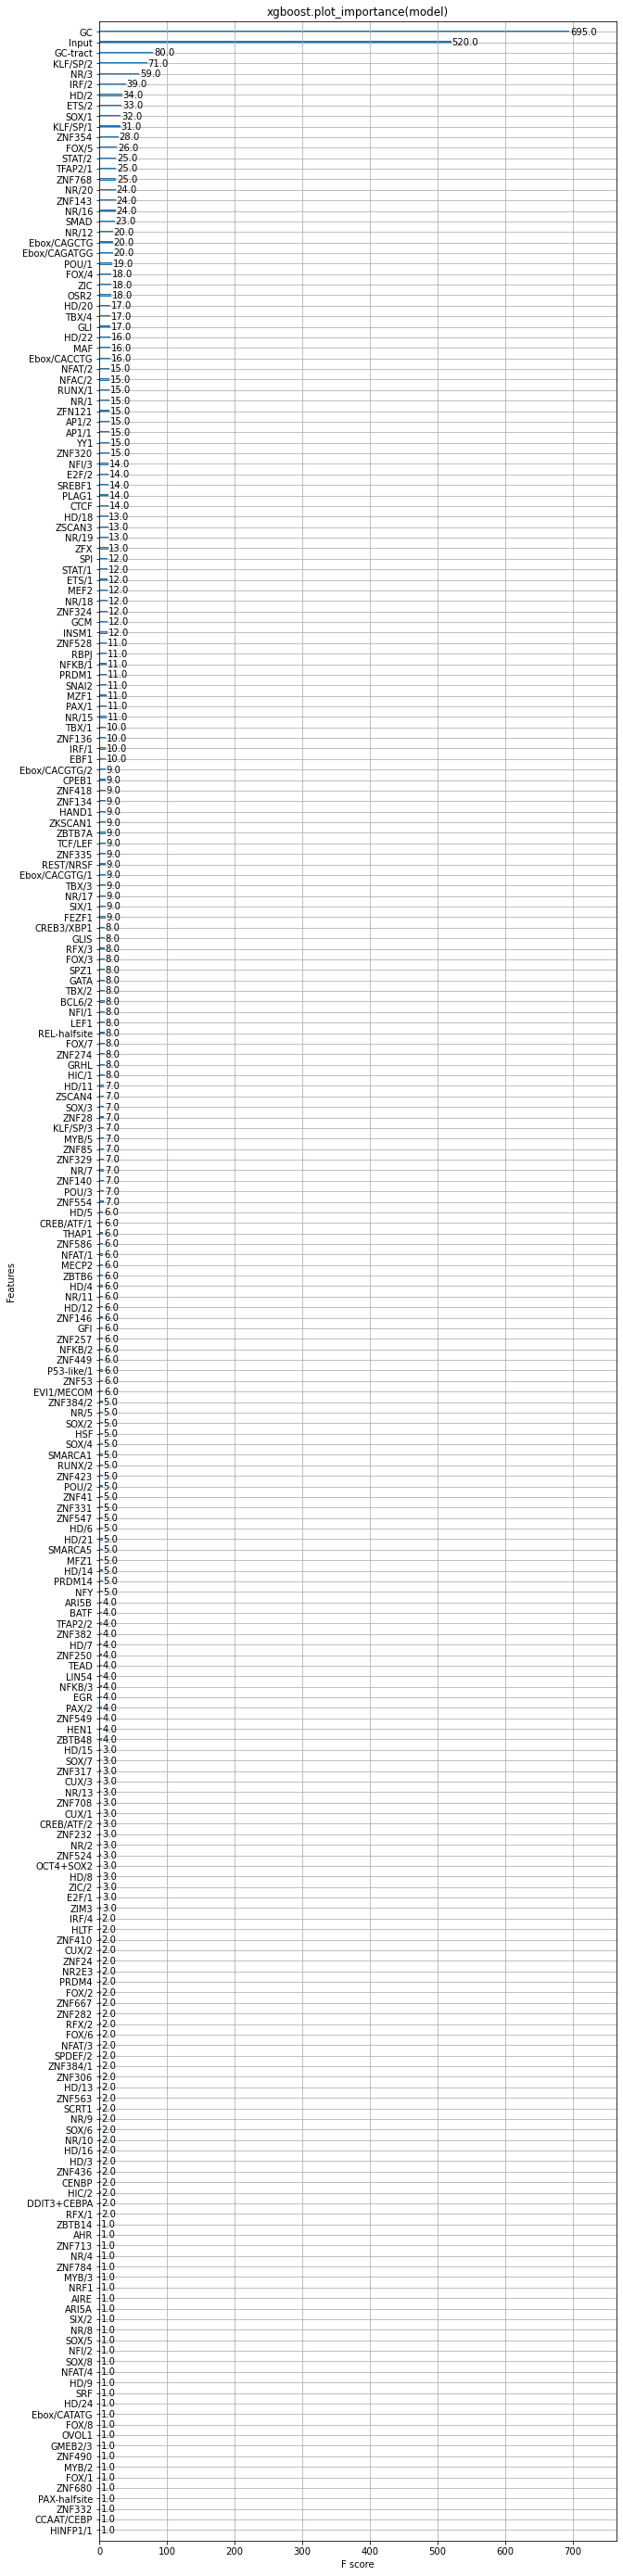

In [32]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 50))
xgb.plot_importance(model, ax = ax)
ax.set_title("xgboost.plot_importance(model)")
plt.show()

## Try SHAP values

In [40]:
model

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, objective='binary:logistic',
              predictor='auto', random_state=0, reg_alpha=0, ...)

In [ ]:
%%time
#Get shap values
explainer = shap.TreeExplainer(model)
shap_values = explainer(X_test)
shap_interaction = explainer.shap_interaction_values(X_test)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [45]:
dat1.Fragment[341:]

341       chr17_8154668_8155710
342       chr17_8154803_8155791
343       chr17_8154803_8155792
344       chr17_8154803_8155793
345       chr17_8154804_8155793
                 ...           
2606    chr17_82268021_82268899
2607    chr17_82268031_82268998
2608    chr17_82268031_82268999
2609    chr17_82268032_82268997
2610    chr17_82268032_82268999
Name: Fragment, Length: 10461, dtype: object

In [48]:
dat3.Fragment[340:]

340       chr17_8154668_8155710
341       chr17_8154803_8155791
342       chr17_8154803_8155792
343       chr17_8154803_8155793
344       chr17_8154804_8155793
                 ...           
2606    chr17_82268021_82268899
2607    chr17_82268031_82268998
2608    chr17_82268031_82268999
2609    chr17_82268032_82268997
2610    chr17_82268032_82268999
Name: Fragment, Length: 10462, dtype: object

In [52]:
dat1.Fragment[341:401].values == dat3.Fragment[340:400].values

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False])

In [15]:
sample = "TFX2_DMSO"
dat_mtf = read_motif_count(sample)
dat_mtf

,Fragment,Motif_Count
0,chr17_6001570_6002624,"{""HD/23"": 1, ""SOX/1"": 2, ""EVI1/MECOM"": 1, ""ZNF..."
1,chr17_6001571_6002624,"{""SOX/1"": 2, ""EVI1/MECOM"": 1, ""ZNF768"": 1, ""NF..."
2,chr17_6001762_6002691,"{""ZNF549"": 2, ""FEZF1"": 2, ""GCM"": 1, ""SIX/1"": 1..."
3,chr17_6001762_6002692,"{""ZNF549"": 2, ""FEZF1"": 2, ""GCM"": 1, ""SIX/1"": 1..."
4,chr17_6001763_6002692,"{""ZNF549"": 2, ""FEZF1"": 2, ""GCM"": 1, ""SIX/1"": 1..."
...,...,...
3447,chr17_82268017_82268885,"{""KLF/SP/1"": 5, ""SPDEF/1"": 1, ""NR/18"": 3, ""NR/..."
3448,chr17_82268044_82269088,"{""ZNF768"": 3, ""Ebox/CAGCTG"": 4, ""ZFN121"": 3, ""..."
3449,chr17_82268045_82269088,"{""Ebox/CAGCTG"": 4, ""ZFN121"": 3, ""ZIC"": 2, ""SCR..."
3450,chr17_82268050_82269088,"{""ZFN121"": 3, ""ZIC"": 2, ""SCRT1"": 3, ""IRF/1"": 2..."


In [17]:
sample = "TFX2_DMSO"
dat_pct = read_pct(sample)
dat_pct

,Fragment,GC
0,chr17_6001570_6002624,0.541746
1,chr17_6001571_6002624,0.542260
2,chr17_6001762_6002691,0.528525
3,chr17_6001762_6002692,0.527957
4,chr17_6001763_6002692,0.528525
...,...,...
3447,chr17_82268017_82268885,0.534562
3448,chr17_82268044_82269088,0.531609
3449,chr17_82268045_82269088,0.532119
3450,chr17_82268050_82269088,0.531792


In [19]:
for dat1, dat2 in zip(dat_mtf, dat_pct):
    res = np.all(dat1.Fragment == dat2.Fragment)
    print(res)

AttributeError: 'str' object has no attribute 'Fragment'

In [9]:
dat_pct

,Fragment,GC
0,chr17_6001570_6002624,0.541746
1,chr17_6001571_6002624,0.542260
2,chr17_6001762_6002691,0.528525
3,chr17_6001762_6002692,0.527957
4,chr17_6001763_6002692,0.528525
...,...,...
3447,chr17_82268017_82268885,0.534562
3448,chr17_82268044_82269088,0.531609
3449,chr17_82268045_82269088,0.532119
3450,chr17_82268050_82269088,0.531792


In [10]:
fun = read_motif_count
lst = list(map(fun, TFX_DMSO))

fun = lambda df1, df2: pd.concat([df1, df2])
dat = reduce(fun, lst)

### assign and show
dat_dmso_mtf = dat
print(dat.shape)
dat

(10802, 2)


,Fragment,Motif_Count
0,chr17_6001570_6002624,"{""HD/23"": 1, ""SOX/1"": 2, ""EVI1/MECOM"": 1, ""ZNF..."
1,chr17_6001571_6002624,"{""SOX/1"": 2, ""EVI1/MECOM"": 1, ""ZNF768"": 1, ""NF..."
2,chr17_6001762_6002691,"{""ZNF549"": 2, ""FEZF1"": 2, ""GCM"": 1, ""SIX/1"": 1..."
3,chr17_6001762_6002692,"{""ZNF549"": 2, ""FEZF1"": 2, ""GCM"": 1, ""SIX/1"": 1..."
4,chr17_6001763_6002692,"{""ZNF549"": 2, ""FEZF1"": 2, ""GCM"": 1, ""SIX/1"": 1..."
...,...,...
2606,chr17_82268021_82268899,"{""NR/4"": 1, ""E2F/2"": 2, ""ZFX"": 2, ""NR/3"": 4, ""..."
2607,chr17_82268031_82268998,"{""Ebox/CAGATGG"": 3, ""ZNF768"": 3, ""Ebox/CAGCTG""..."
2608,chr17_82268031_82268999,"{""Ebox/CAGATGG"": 3, ""ZNF768"": 3, ""Ebox/CAGCTG""..."
2609,chr17_82268032_82268997,"{""Ebox/CAGATGG"": 3, ""ZNF768"": 3, ""Ebox/CAGCTG""..."


In [11]:
fun = read_pct
lst = list(map(fun, TFX_DMSO))

fun = lambda df1, df2: pd.concat([df1, df2])
dat = reduce(fun, lst)

### assign and show
dat_dmso_pct = dat
print(dat.shape)
dat

(10802, 2)


,Fragment,Motif_Count
0,chr17_6001570_6002624,0.541746
1,chr17_6001571_6002624,0.542260
2,chr17_6001762_6002691,0.528525
3,chr17_6001762_6002692,0.527957
4,chr17_6001763_6002692,0.528525
...,...,...
2606,chr17_82268021_82268899,0.535308
2607,chr17_82268031_82268998,0.529473
2608,chr17_82268031_82268999,0.528926
2609,chr17_82268032_82268997,0.528497


In [102]:
fun = read_data
lst = list(map(fun, TFX_DEX))

fun = lambda df1, df2: pd.concat([df1, df2])
dat = reduce(fun, lst)

### assign and show
dat_tfx_dex = dat
print(dat.shape)
dat

(39176, 2)


,Fragment,Motif_Count
0,chr17_6001786_6002741,"{""SIX/1"": 1, ""HIC/1"": 3, ""P53-like/1"": 2, ""GC-..."
1,chr17_6001796_6002785,"{""HIC/1"": 3, ""P53-like/1"": 2, ""GC-tract"": 6, ""..."
2,chr17_6001796_6002786,"{""HIC/1"": 3, ""P53-like/1"": 2, ""GC-tract"": 6, ""..."
3,chr17_6001797_6002783,"{""HIC/1"": 3, ""P53-like/1"": 2, ""GC-tract"": 6, ""..."
4,chr17_6001797_6002786,"{""HIC/1"": 3, ""P53-like/1"": 2, ""GC-tract"": 6, ""..."
...,...,...
11873,chr17_82267754_82268685,"{""MAF"": 1, ""Ebox/CAGATGG"": 4, ""ZNF320"": 2, ""GC..."
11874,chr17_82267762_82268716,"{""ZNF320"": 2, ""GC-tract"": 6, ""SMARCA5"": 2, ""ZN..."
11875,chr17_82267763_82268716,"{""ZNF320"": 2, ""GC-tract"": 6, ""SMARCA5"": 2, ""ZN..."
11876,chr17_82267768_82268716,"{""SMARCA5"": 2, ""ZNF143"": 1, ""ZNF134"": 2, ""INSM..."


In [106]:
lst = dat_tfx_dmso["Motif_Count"].to_list() + dat_tfx_dex["Motif_Count"].to_list()
lst = list(map(json.loads, lst))
dat = pd.DataFrame.from_dict(lst).fillna(0)
dat

,HD/23,SOX/1,EVI1/MECOM,ZNF768,NFY,EBF1,GC-tract,ZNF320,CTCF,KLF/SP/2,...,HSFY2,NR/4,ZNF713,TATA,AHR,ARI5B,GMEB2/1,ZBTB14,GMEB2/2,KAISO
0,1.0,2.0,1.0,1.0,1.0,1.0,8.0,2.0,2.0,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,2.0,1.0,1.0,1.0,1.0,8.0,2.0,2.0,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,2.0,0.0,0.0,0.0,0.0,6.0,0.0,1.0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,2.0,0.0,0.0,0.0,0.0,6.0,0.0,1.0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,2.0,0.0,0.0,0.0,0.0,6.0,0.0,1.0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49973,0.0,1.0,0.0,4.0,0.0,1.0,6.0,2.0,3.0,4.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
49974,0.0,1.0,0.0,4.0,0.0,1.0,6.0,2.0,3.0,4.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
49975,0.0,1.0,0.0,4.0,0.0,1.0,6.0,2.0,3.0,4.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
49976,0.0,1.0,0.0,4.0,0.0,1.0,5.0,1.0,3.0,4.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [107]:
ftr = dat.columns.values
X   = dat #.values
y   = np.r_[np.repeat(0, dat_tfx_dmso.shape[0]), np.repeat(1, dat_tfx_dex.shape[0])]

print(type(X),   X.shape)
print(type(y),   y.shape)
print(type(ftr), ftr.shape)
Counter(y)

<class 'pandas.core.frame.DataFrame'> (49978, 269)
<class 'numpy.ndarray'> (49978,)
<class 'numpy.ndarray'> (269,)


Counter({0: 10802, 1: 39176})

In [108]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [109]:
model = xgb.XGBClassifier()
model.fit(X_train, y_train)
print(); print(model)


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, objective='binary:logistic',
              predictor='auto', random_state=0, reg_alpha=0, ...)


In [110]:
y_expc = y_test
y_pred = model.predict(X_test)

print(metrics.classification_report(y_expc, y_pred))
print(metrics.confusion_matrix(y_expc, y_pred))

              precision    recall  f1-score   support

           0       0.74      0.22      0.34      2701
           1       0.82      0.98      0.89      9794

    accuracy                           0.81     12495
   macro avg       0.78      0.60      0.61     12495
weighted avg       0.80      0.81      0.77     12495

[[ 589 2112]
 [ 209 9585]]


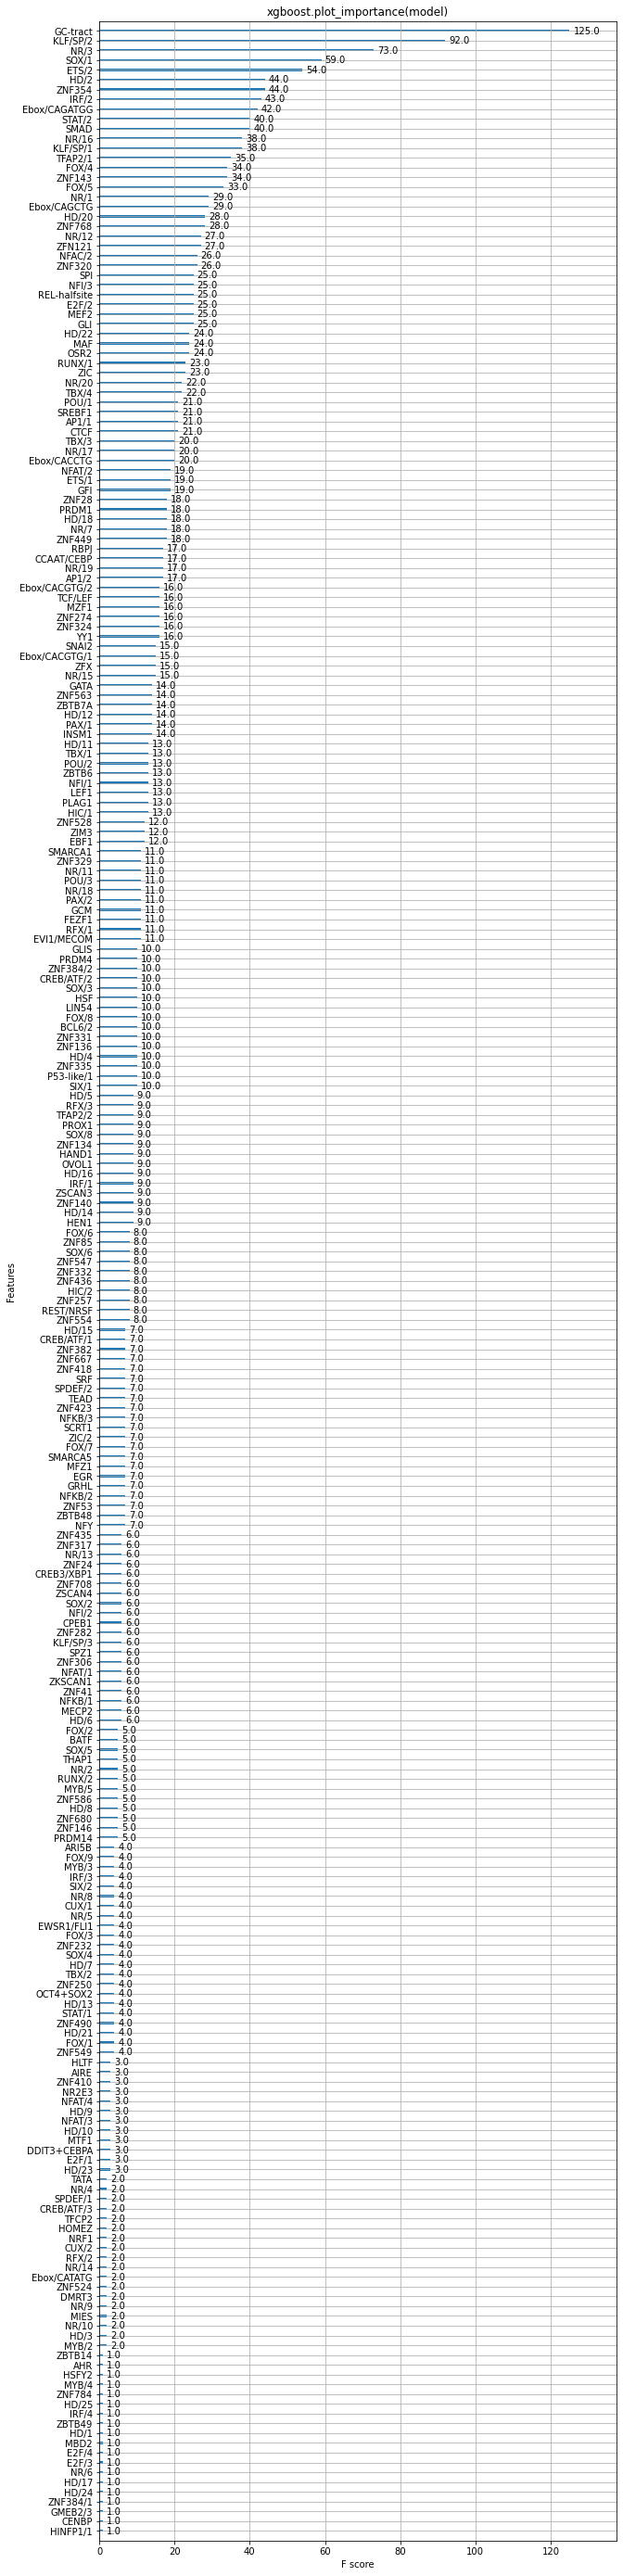

In [111]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 50))
xgb.plot_importance(model, ax = ax)
ax.set_title("xgboost.plot_importance(model)")
plt.show()

In [112]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
print(shap_values.shape)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


(12495, 269)


In [115]:
len(ftr)

269

In [116]:
idx = dat.columns.values
shap.bar_plot(
    shap_values,
    feature_names=ftr,
    max_display=20)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()